## Imports

In [ ]:
# clone the Tensorflow Model Garden
!git clone --depth 1 https://github.com/tensorflow/models/

Cloning into 'models'...
remote: Enumerating objects: 4305, done.
remote: Counting objects: 100% (4305/4305), done.
remote: Compressing objects: 100% (3320/3320), done.
remote: Total 4305 (delta 1210), reused 2166 (delta 912), pack-reused 0 (from 0)
Receiving objects: 100% (4305/4305), 53.16 MiB | 14.61 MiB/s, done.
Resolving deltas: 100% (1210/1210), done.
Updating files: 100% (3875/3875), done.


In [ ]:
# For compatibility. Pin tf-models-official version so it will use Tensorflow 2.15.
!sed -i 's/tf-models-official>=2.5.1/tf-models-official==2.15.0/g' ./models/research/object_detection/packages/tf2/setup.py

# Compile the Object Detection API protocol buffers and install the necessary packages
!cd models/research/ && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.0/152.0 kB 15.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7

In [ ]:
!pip install protobuf==3.20.*

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
!pip install Pillow==9.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 71.7 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: pillow 11.0.0
    Uninstalling pillow-11.0.0:
      Successfully uninstalled pillow-11.0.0


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import zipfile
import io
import imageio
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
from IPython.display import display as ds
import shutil
import requests

# Utilities

In [ ]:
local_zip = '/content/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./')
zip_ref.close()

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

/content/train/images/1.jpg
/content/train/images/2.jpg
/content/train/images/3.jpg
/content/train/images/4.jpg
/content/train/images/5.jpg
/content/train/images/6.jpg
/content/train/images/7.jpg
/content/train/images/8.jpg
/content/train/images/9.jpg
/content/train/images/10.jpg
/content/train/images/11.jpg
/content/train/images/12.jpg
/content/train/images/13.jpg
/content/train/images/14.jpg
/content/train/images/15.jpg
/content/train/images/16.jpg
/content/train/images/17.jpg
/content/train/images/18.jpg
/content/train/images/19.jpg
/content/train/images/20.jpg
/content/train/images/21.jpg
/content/train/images/22.jpg
/content/train/images/23.jpg
/content/train/images/24.jpg
/content/train/images/25.jpg
/content/train/images/26.jpg
/content/train/images/27.jpg
/content/train/images/28.jpg
/content/train/images/29.jpg
/content/train/images/30.jpg
/content/train/images/31.jpg
/content/train/images/32.jpg
/content/train/images/33.jpg
/content/train/images/34.jpg
/content/train/images/3

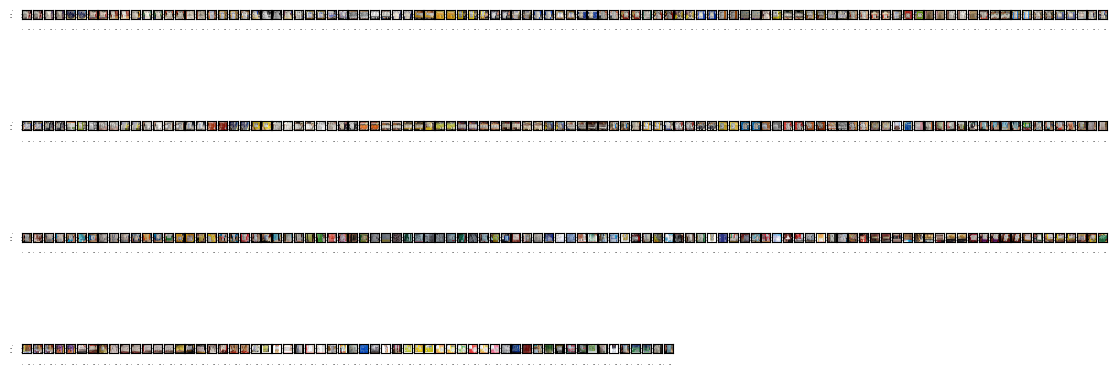

In [ ]:
%matplotlib inline

# assign the name (string) of the directory containing the training images
train_image_dir = '/content/train/images'

# declare an empty list
train_images_np = []

# run a for loop for each image
for i in range(1, 361):
  image_path = os.path.join(train_image_dir, str(i) + '.jpg')
  print(image_path)
  resImg=Image.open(image_path)
  resImg=resImg.resize((640,640))
  train_images_np.append(np.array(resImg))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(5, 100, idx+1)
  plt.imshow(train_image_np)
plt.show()

In [ ]:
print(train_images_np)

[array([[[171, 167, 156],
        [172, 168, 157],
        [173, 169, 158],
        ...,
        [221,  63,  64],
        [222,  66,  69],
        [225,  71,  73]],

       [[177, 170, 160],
        [176, 169, 159],
        [175, 168, 158],
        ...,
        [226,  66,  68],
        [227,  71,  74],
        [230,  74,  77]],

       [[176, 166, 157],
        [173, 163, 154],
        [170, 160, 151],
        ...,
        [234,  71,  76],
        [231,  70,  75],
        [229,  70,  74]],

       ...,

       [[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [110, 107, 100],
        [112, 109, 104],
        [114, 111, 106]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [109, 106, 101],
        [110, 107, 102],
        [110, 107, 102]],

       [[  3,   3,   3],
        [  3,   3,   3],
        [  3,   3,   3],
        ...,
        [109, 106, 101],
        [108, 105, 100],
        [108, 105, 100]

# Read bounding boxes




In [ ]:
gt_boxes = []

In [ ]:
# Read the CSV file into a DataFrame
csv_file_path = '/content/train/gt_boxes.csv'
df = pd.read_csv(csv_file_path)

# Convert the DataFrame to a list of lists
gt_boxes_csv = df.values.tolist()

# Iterate over each list in gt_boxes_csv
for gt_box in gt_boxes_csv:
    # Format the output and append to the new list
    gt_boxes.append(np.array([gt_box]))

In [ ]:
for gt_box in gt_boxes:
  print(gt_box)

[[0.11108025 0.1296875  0.63774692 0.571875  ]]
[[0.11441358 0.1265625  0.63274692 0.5765625 ]]
[[0.15941358 0.20625    0.87941358 0.69375   ]]
[[0.15941358 0.209375   0.87608025 0.6984375 ]]
[[0.0394184 0.1875    0.9044184 0.7890625]]
[[0.0344184  0.1953125  0.89275174 0.78125   ]]
[[0.01275174 0.1484375  0.82775174 0.7921875 ]]
[[0.0144184  0.15       0.82275174 0.8046875 ]]
[[0.04775174 0.203125   0.81275174 0.64375   ]]
[[0.0394184  0.203125   0.77775174 0.65      ]]
[[0.07275174 0.034375   0.87608507 0.746875  ]]
[[0.0294184  0.2078125  0.83775174 0.809375  ]]
[[0.02275174 0.203125   0.83775174 0.7890625 ]]
[[0.05608507 0.296875   0.89775174 0.8125    ]]
[[0.0594184  0.2890625  0.91108507 0.8125    ]]
[[0.05108507 0.209375   0.7994184  0.8828125 ]]
[[0.05275174 0.2046875  0.80108507 0.8828125 ]]
[[0.15775174 0.2765625  0.81275174 0.703125  ]]
[[0.3344184  0.265625   0.84775174 0.6296875 ]]
[[0.3294184 0.2625    0.8544184 0.6328125]]
[[0.3494184  0.3078125  0.87775174 0.64375   ]]


In [ ]:
print(type(train_images_np),"\n",len(train_images_np),"\n",type(train_images_np[0]),"\n",train_images_np[0].shape)

<class 'list'> 
 360 
 <class 'numpy.ndarray'> 
 (640, 640, 3)


In [ ]:
images_label = []

for i in range(1, 361):
  images_label.append(0)

images_label = np.array(images_label)

In [ ]:
print(images_label)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np , images_label_np) in zip(
    train_images_np, gt_boxes , images_label):

  train_image_tensors.append(
      tf.expand_dims(
          tf.convert_to_tensor(
              train_image_np, dtype=tf.float32 ) , axis=0)
      )

  gt_box_tensors.append(
      tf.convert_to_tensor(gt_box_np, dtype=tf.float32))

  zero_indexed_groundtruth_classes = tf.convert_to_tensor( images_label_np )

  gt_classes_one_hot_tensors.append(
      tf.expand_dims(
          tf.one_hot(zero_indexed_groundtruth_classes, 1), axis=0)
  )
print('Done prepping data.')

Done prepping data.


In [ ]:
print('\n gt_classes_one_hot_tensors[0] \n gt_box_tensors[0] \n train_image_tensors[0].shape\n\n')
print(gt_classes_one_hot_tensors[0])
print(gt_box_tensors[0])
print(train_image_tensors[0].shape)


 gt_classes_one_hot_tensors[0] 
 gt_box_tensors[0] 
 train_image_tensors[0].shape


tf.Tensor([[1.]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.11108025 0.1296875  0.63774693 0.571875  ]], shape=(1, 4), dtype=float32)
(1, 640, 640, 3)


# Visualize the image


In [ ]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(
     image,
     class_names,
     boxes):
  ymin, xmin, ymax, xmax = tuple(boxes)
  colors = list(ImageColor.colormap.values())
  font_type = 'LiberationSansNarrow-Regular.ttf'
  font_size = 10
  #font = ImageFont.truetype(font_type,10 ,encoding='utf-8')
  font = ImageFont.load_default()
  display_str = (class_names)
  color = colors[hash(class_names) % len(colors)]
  image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
  draw_bounding_box_on_image(
        image_pil,
        ymin,
        xmin,
        ymax,
        xmax,
        color,
        font,
        display_str_list=[display_str])
  ds( Image.fromarray(np.uint8( np.array(image_pil) )).convert("RGB") )
  #return image

In [ ]:
train_images_np[0].shape

(640, 640, 3)

In [ ]:
label_map= { 0: "Informasi Nilai Gizi"}

In [ ]:
for i in range(0, 5):
  draw_boxes(train_images_np[i], label_map[my_images_label[i]],  gt_boxes[i][0] )

# Create model and restore weights

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2024-12-04 02:29:24--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.118.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  21.3MB/s    in 12s     

2024-12-04 02:29:36 (20.0 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [ ]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = 1
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Training loop



In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 5
learning_rate = 0.01
num_batches = 200

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


batch 0 of 200, loss=1.7695825
batch 10 of 200, loss=0.7695466
batch 20 of 200, loss=0.97252786
batch 30 of 200, loss=0.9664711
batch 40 of 200, loss=0.8312609
batch 50 of 200, loss=0.6129844
batch 60 of 200, loss=0.5513288
batch 70 of 200, loss=0.47862232
batch 80 of 200, loss=0.6815323
batch 90 of 200, loss=0.44526538
batch 100 of 200, loss=0.4259438
batch 110 of 200, loss=0.3033958
batch 120 of 200, loss=0.7086109
batch 130 of 200, loss=0.563812
batch 140 of 200, loss=1.055171
batch 150 of 200, loss=0.44975275
batch 160 of 200, loss=0.376548
batch 170 of 200, loss=0.58835846
batch 180 of 200, loss=0.5674307
batch 190 of 200, loss=0.4318039
Done fine-tuning!


In [ ]:
import inspect
lines = inspect.getsource(train_step_fn)
print(lines)


  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_clas

# Load test images

In [ ]:
def draw_boxes_s(
     image,
     class_names,
     boxes,
     scores,
     score_limit):
  now_image_np=np.zeros((image.shape))
  np.copyto(now_image_np , image)

  for i in range(0,len(boxes)):
    if(float(scores[i])>score_limit):
      box , score , class_name = boxes[i] , scores[i] , class_names[i]
      class_name=label_map[class_name]
      ymin, xmin, ymax, xmax = tuple(box)
      colors = list(ImageColor.colormap.values())

      font = ImageFont.load_default()
      display_str = (class_name+":"+str(score))
      color = colors[hash(class_name) % len(colors)]

      image_pil = Image.fromarray(np.uint8(now_image_np)).convert("RGB")

      draw_bounding_box_on_image(
            image_pil,
            ymin,
            xmin,
            ymax,
            xmax,
            color,
            font,
            display_str_list=[display_str])

      np.copyto(now_image_np, np.array(image_pil) )

  ds(Image.fromarray(np.uint8( np.array(now_image_np) )).convert("RGB") )
  #return image

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(shape=[None,640,640,3], dtype=tf.float32)])
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

In [ ]:
def img_to_tensor(img_np):
  img_tf = tf.convert_to_tensor(img_np, dtype=tf.float32 )
  img_tf = tf.expand_dims(img_tf, axis=0)
  return img_tf

def img_proccess(img):
  img = Image.open(img)

  detection_img = img.resize((640,640))
  detection_img = np.array(detection_img)

  img = np.array(img)
  origin_img = np.zeros(img.shape)

  np.copyto(origin_img ,img)

  detection_img = img_to_tensor(detection_img)

  return {'origin_img_np':origin_img , 'detection_img_tensor':detection_img}

Instructions for updating:
Use fn_output_signature instead
<ipython-input-18-61bf9058ae5c>:23: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-18-61bf9058ae5c>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


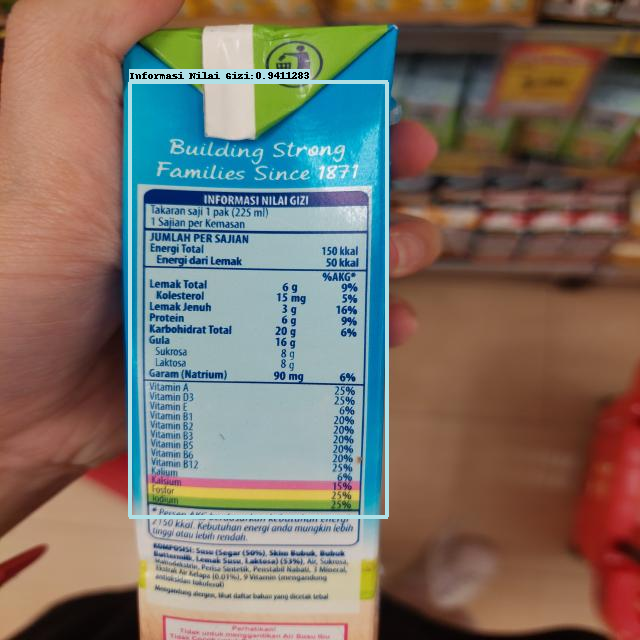

In [ ]:
path_test_img = "/content/20240517_125041_jpg.rf.dbefe4e10c6926ef21f9aaf776f4bd9a.jpg"
path_test_img = img_proccess(path_test_img)

detections=detect( path_test_img["detection_img_tensor"] )

draw_boxes_s(
    path_test_img['origin_img_np'],
    detections['detection_classes'][0].numpy(),
    detections['detection_boxes'][0].numpy(),
    detections["detection_scores"][0].numpy(),
    0.8)

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.saved_model.save(
    detection_model , './save_model',
    signatures={
      'detect': detect.get_concrete_function()
    })

In [ ]:
!zip -r /content/save_model.zip /content/save_model

  adding: content/save_model/ (stored 0%)
  adding: content/save_model/assets/ (stored 0%)
  adding: content/save_model/variables/ (stored 0%)
  adding: content/save_model/variables/variables.index (deflated 80%)
  adding: content/save_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/save_model/saved_model.pb (deflated 92%)
  adding: content/save_model/fingerprint.pb (stored 0%)


In [ ]:
new_model=tf.saved_model.load('./save_model')

In [ ]:
new_model.signatures['detect']

<ConcreteFunction (*, input_tensor: TensorSpec(shape=(None, 640, 640, 3), dtype=tf.float32, name='input_tensor')) -> Dict[['raw_detection_scores', TensorSpec(shape=(None, None, 2), dtype=tf.float32, name='raw_detection_scores')], ['detection_scores', TensorSpec(shape=(None, 100), dtype=tf.float32, name='detection_scores')], ['num_detections', TensorSpec(shape=(None,), dtype=tf.float32, name='num_detections')], ['detection_multiclass_scores', TensorSpec(shape=(None, 100, 2), dtype=tf.float32, name='detection_multiclass_scores')], ['detection_anchor_indices', TensorSpec(shape=(None, 100), dtype=tf.int32, name='detection_anchor_indices')], ['detection_classes', TensorSpec(shape=(None, 100), dtype=tf.float32, name='detection_classes')], ['raw_detection_boxes', TensorSpec(shape=(None, None, 4), dtype=tf.float32, name='raw_detection_boxes')], ['detection_boxes', TensorSpec(shape=(None, 100, 4), dtype=tf.float32, name='detection_boxes')]] at 0x7BC9845A67A0>

<ipython-input-18-61bf9058ae5c>:23: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
<ipython-input-18-61bf9058ae5c>:33: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = font.getsize(display_str)


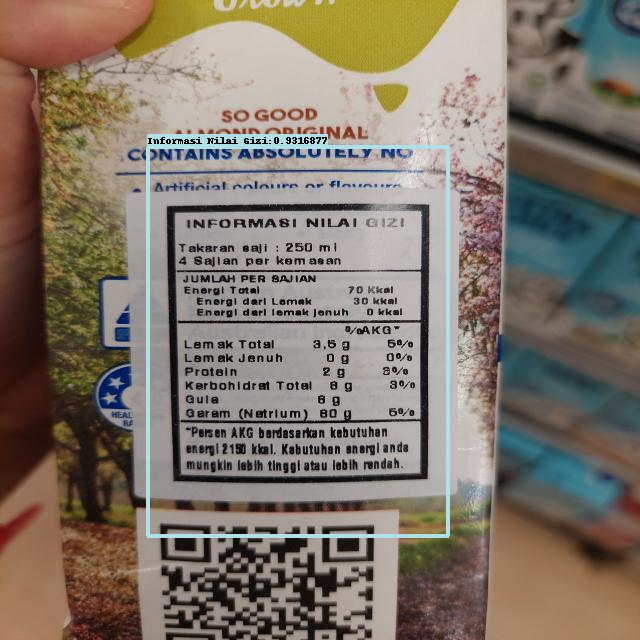

In [ ]:
path_test_img = "/content/20240517_124235_jpg.rf.2f2ed2241cadbf9d74f7c45b12677ad6.jpg"
path_test_img = img_proccess(path_test_img)

detections= new_model.signatures['detect'](path_test_img["detection_img_tensor"])

draw_boxes_s(
    path_test_img['origin_img_np'],
    detections['detection_classes'][0].numpy(),
    detections['detection_boxes'][0].numpy(),
    detections["detection_scores"][0].numpy(),
    0.8)